In [2]:
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='torch')

In [3]:
path = Path('Dataset/asl_alphabet_train/asl_alphabet_train')

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode='zeros'),
    batch_tfms=[
        *aug_transforms(size=224, min_scale=0.75),
        Normalize.from_stats(*imagenet_stats), 
        Brightness(0.1), 
        Contrast(0.1),  
        Rotate(max_deg=10, p=0.5),  
        Dihedral(),  
        RandomResizedCrop(224, min_scale=0.75) 
    ]
)

dls = dblock.dataloaders(path, bs=32)

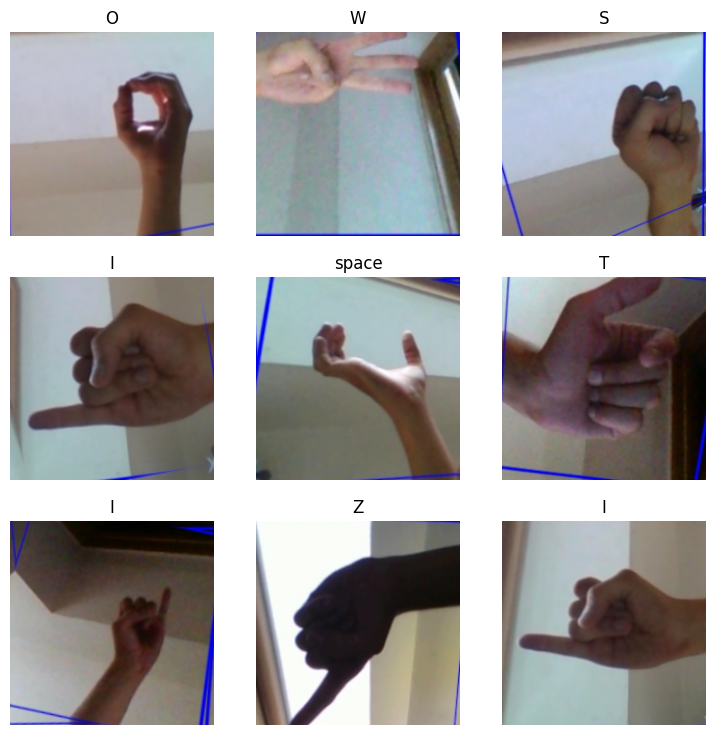

In [5]:
dls.show_batch(max_n=9)

epoch,train_loss,valid_loss,accuracy,time
0,0.722475,0.336462,0.893908,10:32


epoch,train_loss,valid_loss,accuracy,time
0,0.064125,0.011622,0.996667,13:27
1,0.032268,0.002489,0.999310,13:40
2,0.017708,0.000857,0.999770,13:37
3,0.011085,0.000235,1.000000,13:33


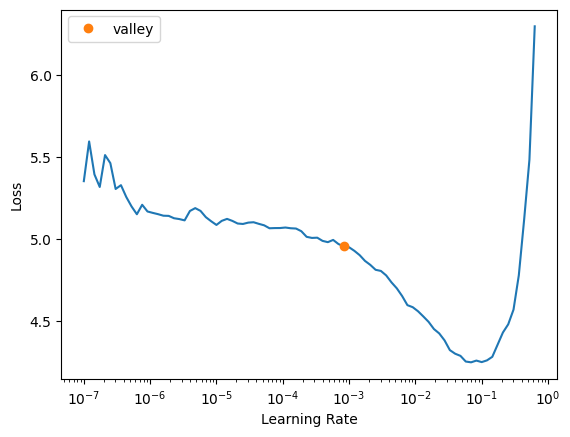

In [6]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

learn.lr_find()

learn.fine_tune(4, base_lr=1e-3)

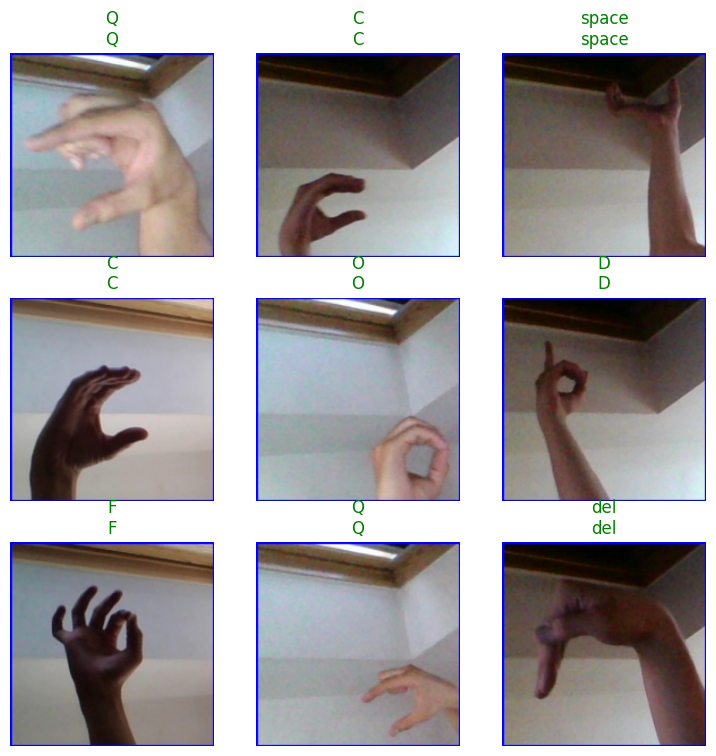

In [7]:
learn.show_results()

In [8]:
learn.export('./models/sign_language_model_v2.pkl')